In [1]:
!pip install gdown

In [4]:
import gdown

file_id = "1D_Uesj--6NaeZ02M-FBlC1RwtiV-fe4k"
url = f"https://drive.google.com/uc?id={file_id}"
output = "myfile.zip"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1D_Uesj--6NaeZ02M-FBlC1RwtiV-fe4k
From (redirected): https://drive.google.com/uc?id=1D_Uesj--6NaeZ02M-FBlC1RwtiV-fe4k&confirm=t&uuid=5fa70457-bc58-4588-995c-ea6c0b7b2b83
To: /content/myfile.zip
100%|██████████| 78.2M/78.2M [00:01<00:00, 44.1MB/s]


'myfile.zip'

In [6]:
import zipfile

with zipfile.ZipFile("myfile.zip", 'r') as zip_ref:
    zip_ref.extractall("folder")

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models, datasets
from glob import glob
import os
import random
from transformers import CLIPVisionModel
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import time
import cv2
from torchvision.datasets import ImageFolder
device = 'cuda' if torch.cuda.is_available() else 'cpu'

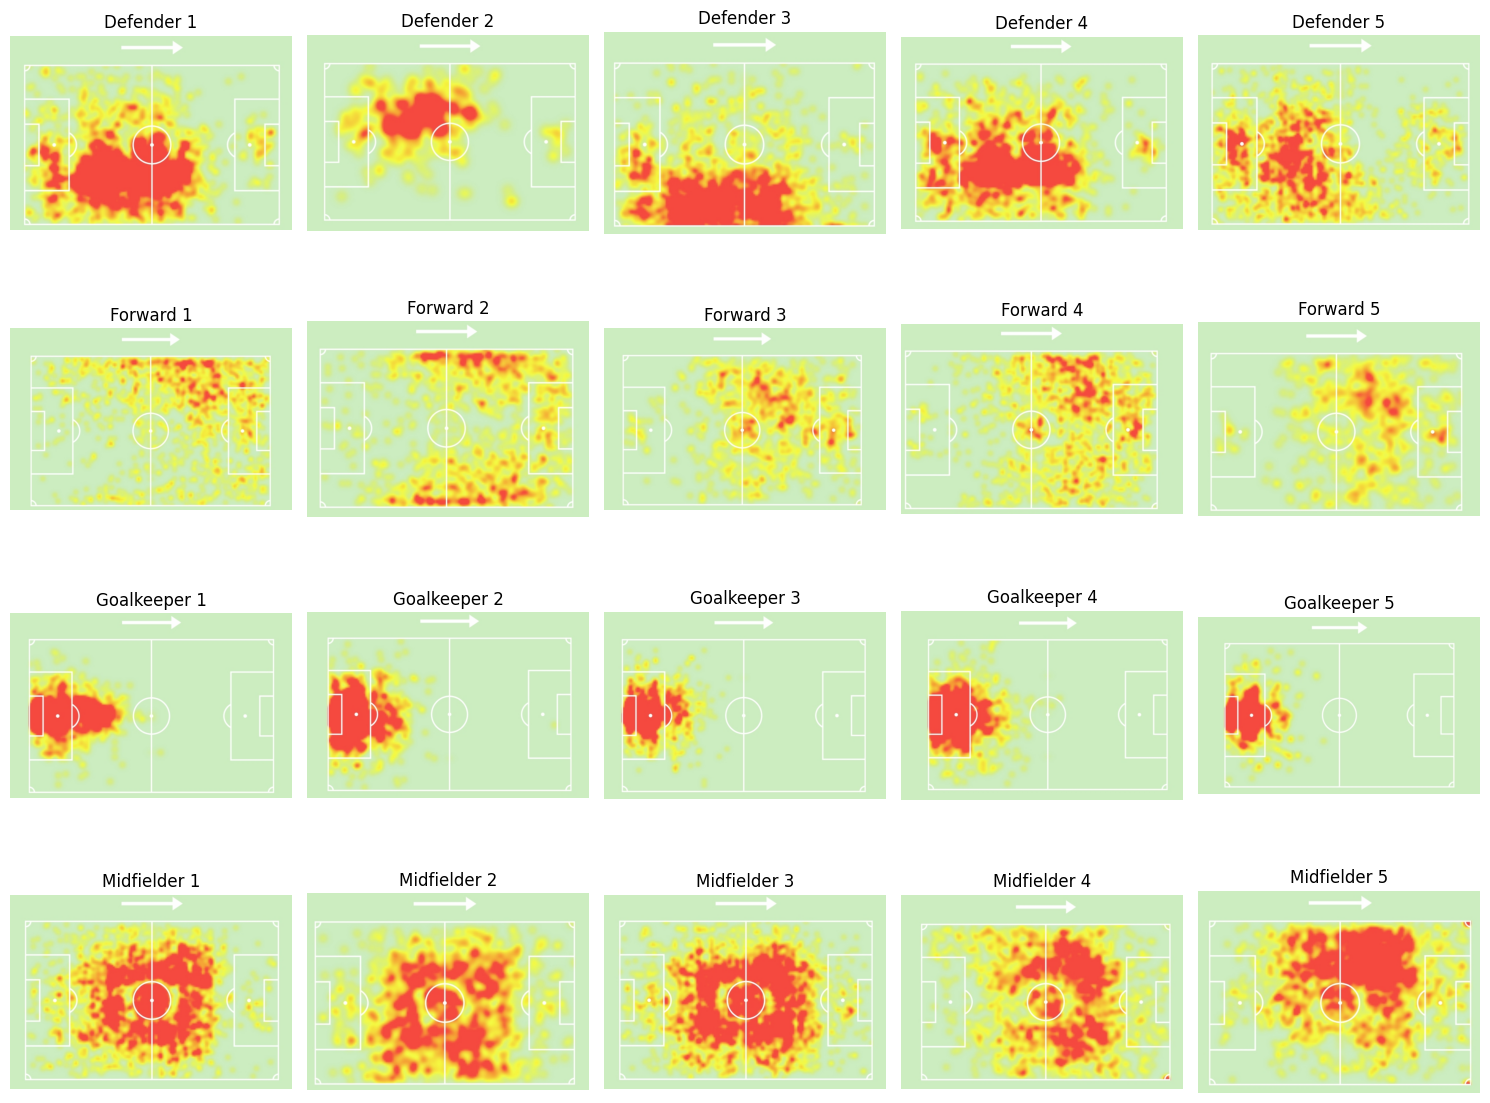

In [3]:
base_path = r"/content/folder/train"
folders = ["Defender", "Forward", "Goalkeeper", "Midfielder"]
samples_per_folder = 5

fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, folder in enumerate(folders):
    folder_path = os.path.join(base_path, folder)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    selected_images = random.sample(image_files, min(samples_per_folder, len(image_files)))

    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{folder} {j+1}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [31]:
transform = A.Compose([
    A.Resize(height=256, width=256),
    A.CenterCrop(height=224, width=224),
    A.Normalize(
        mean=(0.48145466, 0.4578275, 0.40821073),
        std=(0.26862954, 0.26130258, 0.27577711)
    ),
    ToTensorV2()
])

class FootballistaDataset(Dataset):
    def __init__(self, base_path, transform=None):
        self.base_path = base_path
        self.classes = ['Defender', 'Forward', 'Goalkeeper', 'Midfielder']
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self._load_paths()

    def _load_paths(self):
        for idx, cls in enumerate(self.classes):
            cls_path = os.path.join(self.base_path, cls)
            for file in os.listdir(cls_path):
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    self.image_paths.append(os.path.join(cls_path, file))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]
        image = np.array(Image.open(path).convert("RGB"))
        if self.transform:
            image = self.transform(image=image)["image"]
        label = torch.tensor(label, dtype=torch.long)
        return image, label

def split_dataset(dataset, train_size=0.8):
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(
        indices, train_size=train_size, stratify=dataset.labels, random_state=42
    )
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, test_indices)
    return train_dataset, val_dataset

In [32]:
base_path = r"/content/folder/train"
dataset = FootballistaDataset(base_path, transform=transform)
train_dataset, val_dataset = split_dataset(dataset, train_size=0.8)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

In [33]:
train_labels = [dataset.labels[i] for i in train_dataset.indices]
val_labels = [dataset.labels[i] for i in val_dataset.indices]
for cls in dataset.classes:
    train_count = train_labels.count(dataset.classes.index(cls))
    val_count = val_labels.count(dataset.classes.index(cls))
    print(f"{cls} - Train: {train_count}, val: {val_count}")
print('*****************************************')
for batch in train_loader:
    images, labels = batch
    print(f"Train batch - Images shape: {images.shape}, Labels: {labels}")
    break
for batch in val_loader:
    images, labels = batch
    print(f"Val batch - Images shape: {images.shape}, Labels: {labels}")
    break

Defender - Train: 89, val: 22
Forward - Train: 82, val: 21
Goalkeeper - Train: 53, val: 14
Midfielder - Train: 93, val: 23
*****************************************
Train batch - Images shape: torch.Size([5, 3, 224, 224]), Labels: tensor([2, 3, 2, 0, 1])
Val batch - Images shape: torch.Size([5, 3, 224, 224]), Labels: tensor([1, 1, 1, 0, 2])


In [55]:
clip_vision_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
class CLIPClassifier(nn.Module):
    def __init__(self, clip_vision_model, num_classes):
        super().__init__()
        self.clip_vision_model = clip_vision_model
        for param in self.clip_vision_model.parameters():
            param.requires_grad = True

        hidden_dim = clip_vision_model.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
            )


    def forward(self, pixel_values):
        outputs = self.clip_vision_model(pixel_values=pixel_values)
        image_features = outputs.pooler_output
        logits = self.classifier(image_features)
        return logits

model = CLIPClassifier(clip_vision_model, num_classes=4).to(device)
for name, param in model.named_parameters():
    print(name, param.requires_grad)

clip_vision_model.vision_model.embeddings.class_embedding True
clip_vision_model.vision_model.embeddings.patch_embedding.weight True
clip_vision_model.vision_model.embeddings.position_embedding.weight True
clip_vision_model.vision_model.pre_layrnorm.weight True
clip_vision_model.vision_model.pre_layrnorm.bias True
clip_vision_model.vision_model.encoder.layers.0.self_attn.k_proj.weight True
clip_vision_model.vision_model.encoder.layers.0.self_attn.k_proj.bias True
clip_vision_model.vision_model.encoder.layers.0.self_attn.v_proj.weight True
clip_vision_model.vision_model.encoder.layers.0.self_attn.v_proj.bias True
clip_vision_model.vision_model.encoder.layers.0.self_attn.q_proj.weight True
clip_vision_model.vision_model.encoder.layers.0.self_attn.q_proj.bias True
clip_vision_model.vision_model.encoder.layers.0.self_attn.out_proj.weight True
clip_vision_model.vision_model.encoder.layers.0.self_attn.out_proj.bias True
clip_vision_model.vision_model.encoder.layers.0.layer_norm1.weight True


In [57]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0.0

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # --- Training ---
        model.train()
        train_loss, correct_preds, total_preds = 0, 0, 0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            pixel_values, labels = batch
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(pixel_values)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = correct_preds / total_preds
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # --- Validation ---
        model.eval()
        val_loss, correct_preds, total_preds = 0, 0, 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation", leave=False):
                pixel_values, labels = batch
                pixel_values = pixel_values.to(device)
                labels = labels.to(device)

                outputs = model(pixel_values)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct_preds += (preds == labels).sum().item()
                total_preds += labels.size(0)

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = correct_preds / total_preds
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("=> Saved best model weights")

        scheduler.step(epoch_val_acc)

    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()

    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies


Epoch 1/30


Train Loss: 1.3304 | Train Acc: 0.2997 | Val Loss: 1.1091 | Val Acc: 0.6250
=> Saved best model weights

Epoch 2/30


Train Loss: 1.0686 | Train Acc: 0.5741 | Val Loss: 0.7716 | Val Acc: 0.8125
=> Saved best model weights

Epoch 3/30


Train Loss: 0.8091 | Train Acc: 0.7476 | Val Loss: 0.5312 | Val Acc: 0.9375
=> Saved best model weights

Epoch 4/30


Train Loss: 0.6161 | Train Acc: 0.8202 | Val Loss: 0.4433 | Val Acc: 0.9250

Epoch 5/30


Train Loss: 0.5616 | Train Acc: 0.8170 | Val Loss: 0.3606 | Val Acc: 0.9250

Epoch 6/30


Train Loss: 0.5221 | Train Acc: 0.8265 | Val Loss: 0.3827 | Val Acc: 0.9250

Epoch 7/30


Train Loss: 0.3987 | Train Acc: 0.8770 | Val Loss: 0.3118 | Val Acc: 0.9000

Epoch 8/30


Train Loss: 0.3305 | Train Acc: 0.9180 | Val Loss: 0.2624 | Val Acc: 0.9500
=> Saved best model weights

Epoch 9/30


Train Loss: 0.3388 | Train Acc: 0.9085 | Val Loss: 0.2622 | Val Acc: 0.9500

Epoch 10/30


Train Loss: 0.3282 | Train Acc: 0.9022 | Val Loss: 0.2504 | Val Acc: 0.9625
=> Saved best model weights

Epoch 11/30


Train Loss: 0.3154 | Train Acc: 0.8991 | Val Loss: 0.2963 | Val Acc: 0.9125

Epoch 12/30


Train Loss: 0.3044 | Train Acc: 0.9369 | Val Loss: 0.2252 | Val Acc: 0.9625

Epoch 13/30


Train Loss: 0.2819 | Train Acc: 0.9148 | Val Loss: 0.2511 | Val Acc: 0.9375

Epoch 14/30


Train Loss: 0.2543 | Train Acc: 0.9338 | Val Loss: 0.2783 | Val Acc: 0.9000

Epoch 15/30


Train Loss: 0.2318 | Train Acc: 0.9369 | Val Loss: 0.2161 | Val Acc: 0.9625

Epoch 16/30


Train Loss: 0.2270 | Train Acc: 0.9464 | Val Loss: 0.2119 | Val Acc: 0.9500

Epoch 17/30


Train Loss: 0.1891 | Train Acc: 0.9590 | Val Loss: 0.2136 | Val Acc: 0.9375

Epoch 18/30


Train Loss: 0.1915 | Train Acc: 0.9527 | Val Loss: 0.2033 | Val Acc: 0.9500

Epoch 19/30


Train Loss: 0.2022 | Train Acc: 0.9464 | Val Loss: 0.1992 | Val Acc: 0.9500

Epoch 20/30


Train Loss: 0.2024 | Train Acc: 0.9558 | Val Loss: 0.2126 | Val Acc: 0.9375

Epoch 21/30


Train Loss: 0.1838 | Train Acc: 0.9464 | Val Loss: 0.2043 | Val Acc: 0.9500

Epoch 22/30


Train Loss: 0.1966 | Train Acc: 0.9432 | Val Loss: 0.1991 | Val Acc: 0.9500

Epoch 23/30


Train Loss: 0.1825 | Train Acc: 0.9590 | Val Loss: 0.2056 | Val Acc: 0.9375

Epoch 24/30


Train Loss: 0.1699 | Train Acc: 0.9590 | Val Loss: 0.2041 | Val Acc: 0.9375

Epoch 25/30


Train Loss: 0.1720 | Train Acc: 0.9590 | Val Loss: 0.2016 | Val Acc: 0.9375

Epoch 26/30


Train Loss: 0.1627 | Train Acc: 0.9621 | Val Loss: 0.2033 | Val Acc: 0.9375

Epoch 27/30


Train Loss: 0.1764 | Train Acc: 0.9685 | Val Loss: 0.2020 | Val Acc: 0.9375

Epoch 28/30


Train Loss: 0.1976 | Train Acc: 0.9369 | Val Loss: 0.2024 | Val Acc: 0.9375

Epoch 29/30


Train Loss: 0.1727 | Train Acc: 0.9590 | Val Loss: 0.2045 | Val Acc: 0.9375

Epoch 30/30


Train Loss: 0.1688 | Train Acc: 0.9653 | Val Loss: 0.2022 | Val Acc: 0.9375


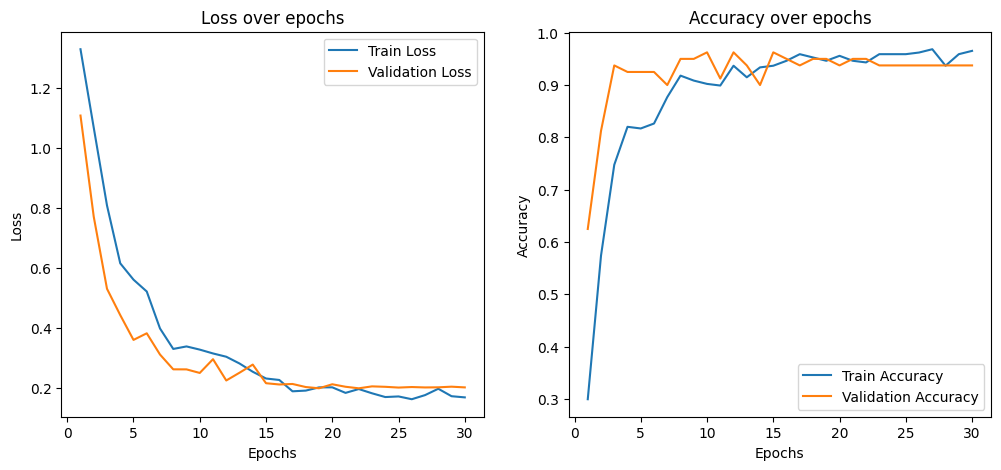

In [58]:
model = CLIPClassifier(clip_vision_model, num_classes=4).to(device)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 30

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=num_epochs
)

In [59]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

CLIPClassifier(
  (clip_vision_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
        (position_embedding): Embedding(197, 768)
      )
      (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
     

In [60]:
def predict(model, folder_path, transform, device):
    model.eval()
    results = []

    classes = ['Defender', 'Forward', 'Goalkeeper', 'Midfielder']

    files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    def extract_number(f):
        match = re.match(r"(\d+)\.jpg", f)
        return int(match.group(1)) if match else float('inf')
    files = sorted(files, key=extract_number)

    with torch.no_grad():
        for file in files:
            image_path = os.path.join(folder_path, file)
            image = np.array(Image.open(image_path).convert("RGB"))
            image = transform(image=image)["image"].unsqueeze(0).to(device)

            outputs = model(image)
            preds = outputs.argmax(dim=1).cpu().item()
            pred_class = classes[preds]

            results.append(pred_class)

    df = pd.DataFrame(results, columns=["Position"])
    return df

In [62]:
df = predict(model, folder_path="/content/folder/test", transform=transform, device=device)
df.to_csv("submission.csv", index=False)

In [63]:
df

,Position
0,Goalkeeper
1,Defender
2,Defender
3,Forward
4,Forward
...,...
160,Defender
161,Defender
162,Forward
163,Forward
